In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon

In [2]:
n_points = 2000
eps = 1e-3
noise_std = 0.2

h_start = 0.03
h_min = 0.02
a = np.sqrt(2)

In [3]:
x = np.linspace(eps, 1.0, n_points)
y_clean = (1 + 0.5 * np.sin(4 * np.pi * x)) * np.sin(2 * np.pi * (6 * x + 12 * x**3))

np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy = y_clean + noise

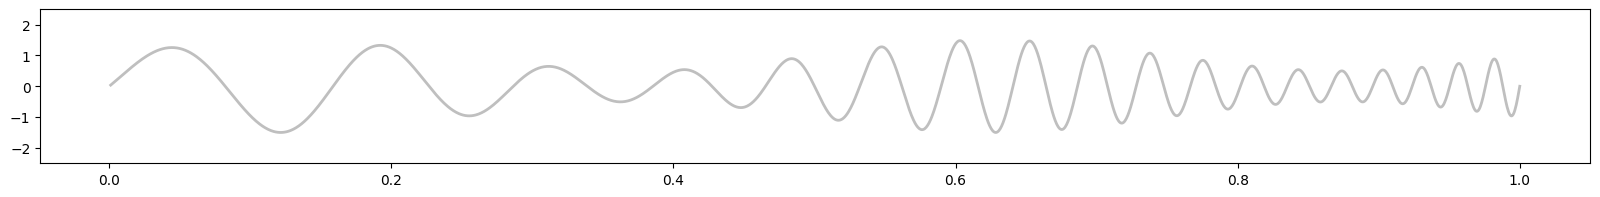

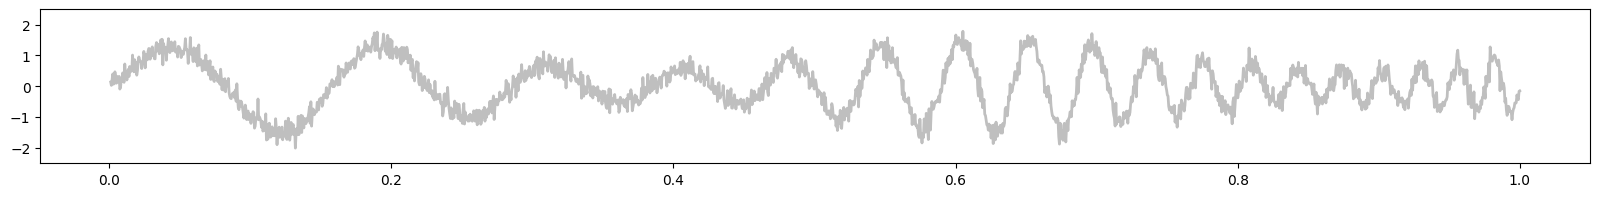

In [4]:
plt.figure(figsize=(20, 2))
plt.plot(x, y_clean, color='gray', linewidth=2, alpha=0.5)
plt.ylim(-2.5, 2.5)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.ylim(-2.5, 2.5)
plt.show()

In [5]:
residuals_list = []
components = []
current_residuals = y_noisy.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]        # Rolling Window
        local_res = current_residuals[indices]
            
        u = (x[indices] - t) / h_curr                                       # s - t / h
        weights = 0.75 * (1 - u**2)                                         # Epanechnikov Kernel
        weights = weights / (weights.sum())
        # print(weights.sum())
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        
    components.append(y_smooth)
    current_residuals = current_residuals - y_smooth
    #very important added by Marc in order to have the residuals from which we create the next IMF
    residuals_list.append(current_residuals)
    h_curr = h_curr / a

print()

###############################################


residuals_list_clean=[]
components_clean = []
current_residuals_clean = y_clean.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]            # Rolling Window
        local_res = current_residuals_clean[indices]
            
        u = (x[indices] - t) / h_curr                                           # s - t / h
        weights = 0.75 * (1 - u**2)                                             # Epanechnikov Kernel
        weights = weights / (weights.sum())
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        
    components_clean.append(y_smooth)
    current_residuals_clean = current_residuals_clean - y_smooth
    #very important added by Marc in order to have the residuals from which we create the next IMF
    residuals_list_clean.append(current_residuals_clean)
    h_curr = h_curr / a

Step 1 | h = 0.03
Step 2 | h = 0.0212

Step 1 | h = 0.03
Step 2 | h = 0.0212


In [6]:
def emd_decompose(y_input, x, h_start=0.1, h_min=0.02, a=np.sqrt(2)):
    residuals_list = []
    components = []
    current_residuals = y_input.copy()
    h_curr = h_start
    count = 0

    while h_curr >= h_min:
        count += 1
        print(f"Step {count} | h = {h_curr:.4f}")
        n = len(x)
        y_smooth = np.zeros(n)

        for i in range(n):
            t = x[i]
            
            indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]    # Rolling Window
            local_res = current_residuals[indices]
                
            u = (x[indices] - t) / h_curr                                   # s - t / h
            weights = 0.75 * (1 - u**2)                                     # Epanechnikov Kernel
            weights = weights / (weights.sum())
            # print(weights.sum())
            
            def loss_function(m):
                return np.sum(np.abs(local_res - m) * weights)
            result = minimize_scalar(loss_function)
        
            if result.success:
                y_smooth[i] = result.x
            
        components.append(y_smooth)
        current_residuals = current_residuals - y_smooth

        residuals_list.append(current_residuals.copy())                     # Store residuals
        h_curr /= a
    
    return components, residuals_list


print("--- Decomposing Noisy Signal ---")
components, residuals_list = emd_decompose(y_noisy, x)

print()
print("--- Decomposing Clean Signal ---")
components_clean, residuals_list_clean = emd_decompose(y_clean, x)

--- Decomposing Noisy Signal ---
Step 1 | h = 0.1000
Step 2 | h = 0.0707
Step 3 | h = 0.0500
Step 4 | h = 0.0354
Step 5 | h = 0.0250

--- Decomposing Clean Signal ---
Step 1 | h = 0.1000
Step 2 | h = 0.0707
Step 3 | h = 0.0500
Step 4 | h = 0.0354
Step 5 | h = 0.0250


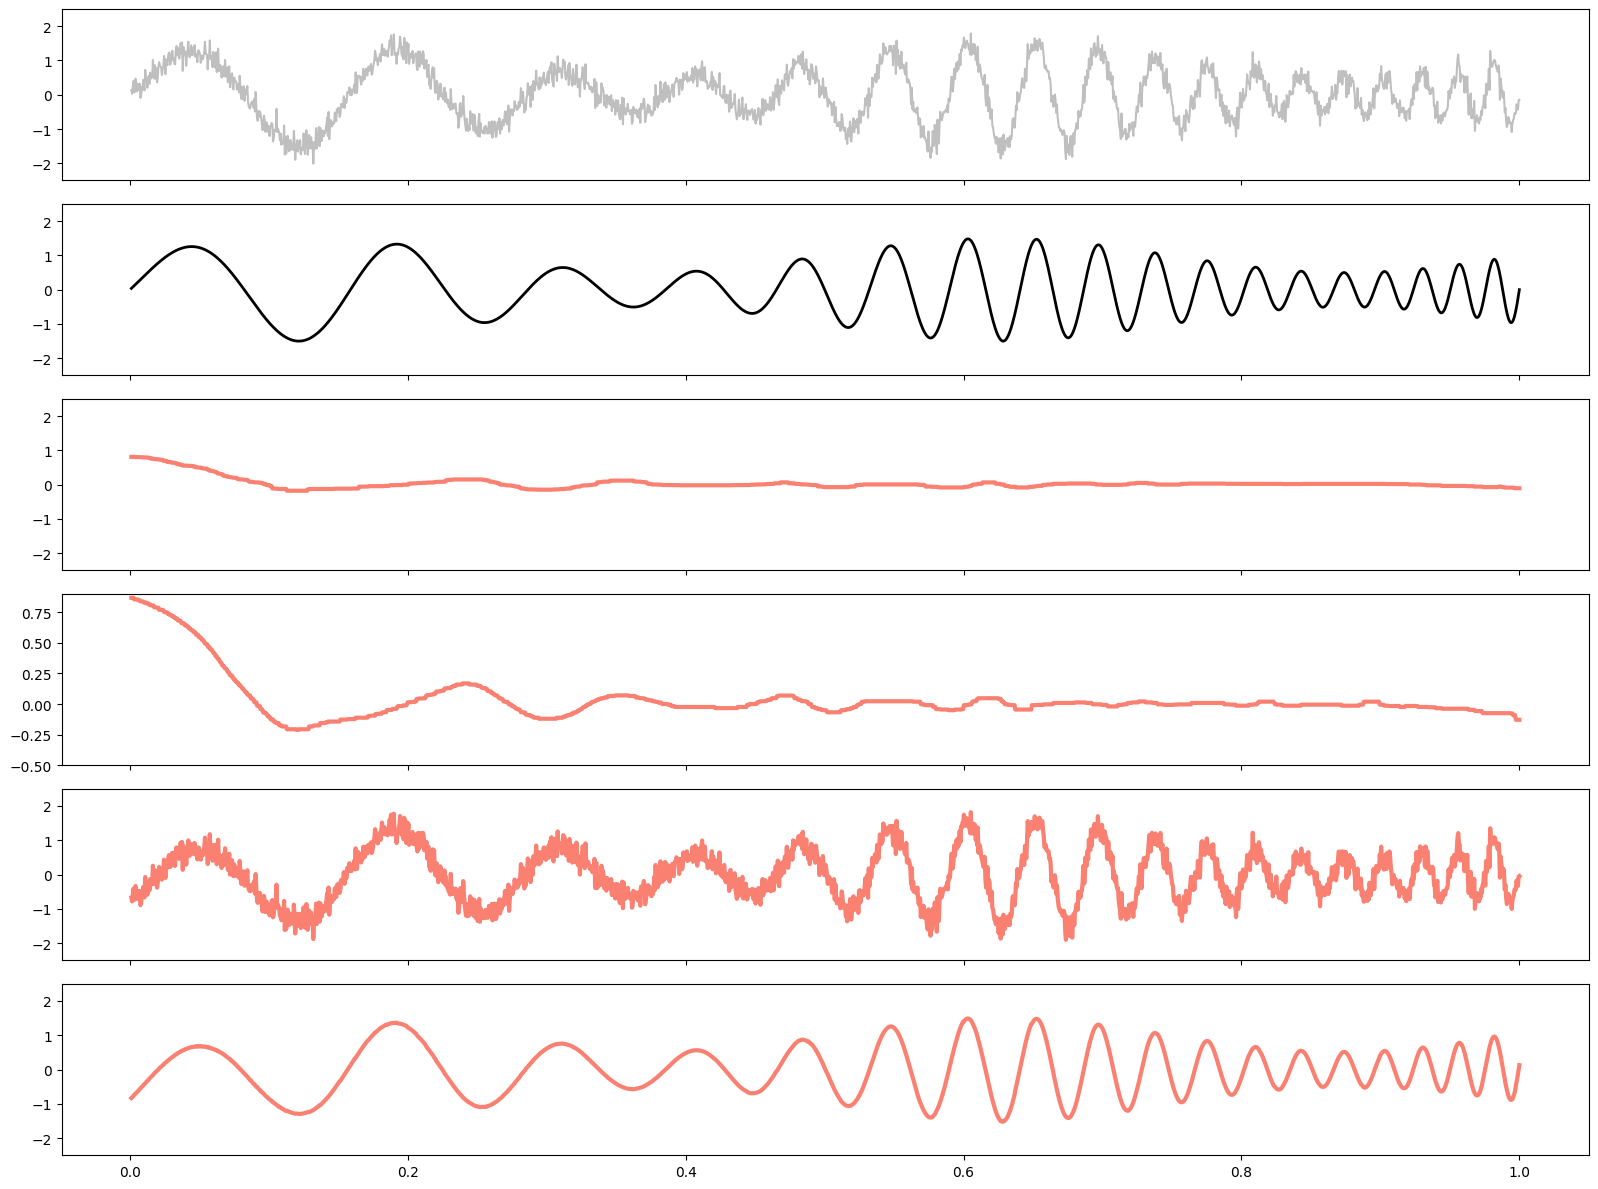

In [20]:
# 20260114 Work

iteration = 0

n_comp = len(components)
fig, axes = plt.subplots(6, 1, figsize=(16, 12), sharex=True)

ax = axes[0]
ax.plot(x, y_noisy, color='gray', linewidth=1.5, alpha=0.5)
ax.set_ylim(-2.5, 2.5)

ax = axes[1]
ax.plot(x, y_clean, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-2.5, 2.5)

ax = axes[2]
ax.plot(x, components[0], color='salmon', linestyle='-', linewidth=3)
ax.set_ylim(-2.5, 2.5)

ax = axes[3]
ax.plot(x, components_clean[0], color='salmon', linestyle='-', linewidth=3)
ax.set_ylim(-0.5, 0.9)

ax = axes[4]
ax.plot(x, residuals_list[0], color='salmon', linestyle='-', linewidth=3)
ax.set_ylim(-2.5, 2.5)

ax = axes[5]
ax.plot(x, residuals_list_clean[0], color='salmon', linestyle='-', linewidth=3)
ax.set_ylim(-2.5, 2.5)

# y_reconstructed = np.zeros_like(x)

# for i, comp in enumerate(components):
#     ax = axes[i+1]
#     ax.plot(x, comp, color='red', linewidth=2)
#     ax.set_ylim(-2.5, 2.5)

#     y_reconstructed += comp

# ax = axes[-1]
# ax.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
# ax.plot(x, y_clean, color='black', linestyle='--', linewidth=1.5)
# ax.plot(x, y_reconstructed, color='red', linewidth=4)
# ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.savefig(f"EMD_Local_6panels_h{h_start}.png", dpi=144, transparent=False)
plt.show()

In [8]:
n_iterations = len(components)
print(f"Generating plots for {n_iterations} iterations...")

for i in range(n_iterations):
    fig, axes = plt.subplots(6, 1, figsize=(16, 12), sharex=True)

    if i == 0:
        current_input_noisy = y_noisy
        current_input_clean = y_clean
    else:
        current_input_noisy = residuals_list[i-1]
        current_input_clean = residuals_list_clean[i-1]

    # Panel 1: Input for this iteration (Noisy)
    ax = axes[0]
    ax.plot(x, current_input_noisy, color='gray', linewidth=1.5, alpha=0.5)
    ax.set_ylim(-2.5, 2.5)

    # Panel 2: Input for this iteration (Clean)
    ax = axes[1]
    ax.plot(x, current_input_clean, color='black', linestyle='-', linewidth=2)
    ax.set_ylim(-2.5, 2.5)

    # Panel 3: Component (Noisy) at iteration i
    ax = axes[2]
    ax.plot(x, components[i], color='salmon', linestyle='-', linewidth=3)
    ax.set_ylim(-2.5, 2.5)

    # Panel 4: Component (Clean) at iteration i
    ax = axes[3]
    ax.plot(x, components_clean[i], color='salmon', linestyle='-', linewidth=3)
    ax.set_ylim(-2.5, 2.5)

    # Panel 5: Residual (Noisy) at iteration i
    ax = axes[4]
    ax.plot(x, residuals_list[i], color='salmon', linestyle='-', linewidth=3)
    ax.set_ylim(-2.5, 2.5)

    # Panel 6: Residual (Clean) at iteration i
    ax = axes[5]
    ax.plot(x, residuals_list_clean[i], color='salmon', linestyle='-', linewidth=3)
    ax.set_ylim(-2.5, 2.5)

    plt.tight_layout()
    
    filename = f"EMD_Local_iteration_{i}_h_{h_start}.png"
    plt.savefig(filename, dpi=144, transparent=True)
    plt.close(fig) 
    
    print(f"Saved: {filename}")

Generating plots for 5 iterations...
Saved: EMD_Local_iteration_0_h_0.03.png
Saved: EMD_Local_iteration_1_h_0.03.png
Saved: EMD_Local_iteration_2_h_0.03.png
Saved: EMD_Local_iteration_3_h_0.03.png
Saved: EMD_Local_iteration_4_h_0.03.png


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=6, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02
)

fig.add_trace(
    go.Scatter(x=x, y=y_noisy, mode="lines",
               line=dict(color="gray", width=1.5),
               opacity=0.5),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=y_clean, mode="lines",
               line=dict(color="black", width=2)),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=components[0], mode="lines",
               line=dict(color="salmon", width=1)),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=components_clean[0], mode="lines",
               line=dict(color="salmon", width=1)),
    row=4, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=residuals_list[0], mode="lines",
               line=dict(color="salmon", width=3)),
    row=5, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=residuals_list_clean[0], mode="lines",
               line=dict(color="salmon", width=3)),
    row=6, col=1
)

for i in range(1, 7):
    fig.update_yaxes(range=[-2.5, 2.5], row=i, col=1)

fig.update_layout(
    width=1600,
    height=1200,
    showlegend=False,
    margin=dict(l=40, r=40, t=40, b=40)
)

# fig.write_image(f"EMD_Local_6panels_h{h_start}.png", scale=5)
fig.show()

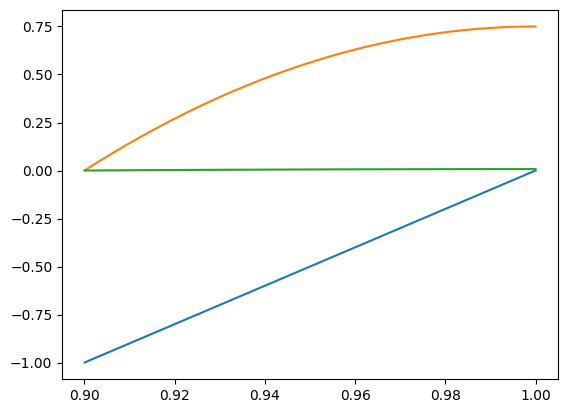

In [60]:
test = np.where((x >= x[1999] - 0.1) & (x <= x[1999] + 0.1))[0]
test_local_res = current_residuals[test]

u = (x[test] - x[1999]) / 0.1
weights = 0.75 * (1 - u**2)
reweights = weights / (weights.sum())

plt.plot(x[test], u)
plt.plot(x[test], weights)
plt.plot(x[test], reweights)
plt.show()

# test = np.where((x >= x[1600] - 0.1) & (x <= x[1600] + 0.1))[0]

# u = (x[test] - x[1600]) / 0.1
# weights = 0.75 * (1 - u**2)
# reweights = weights / weights.sum()

# plt.plot(x[test], u)
# plt.plot(x[test], weights)
# plt.plot(x[test], reweights)
# plt.show()

Processing with h = 0.1...


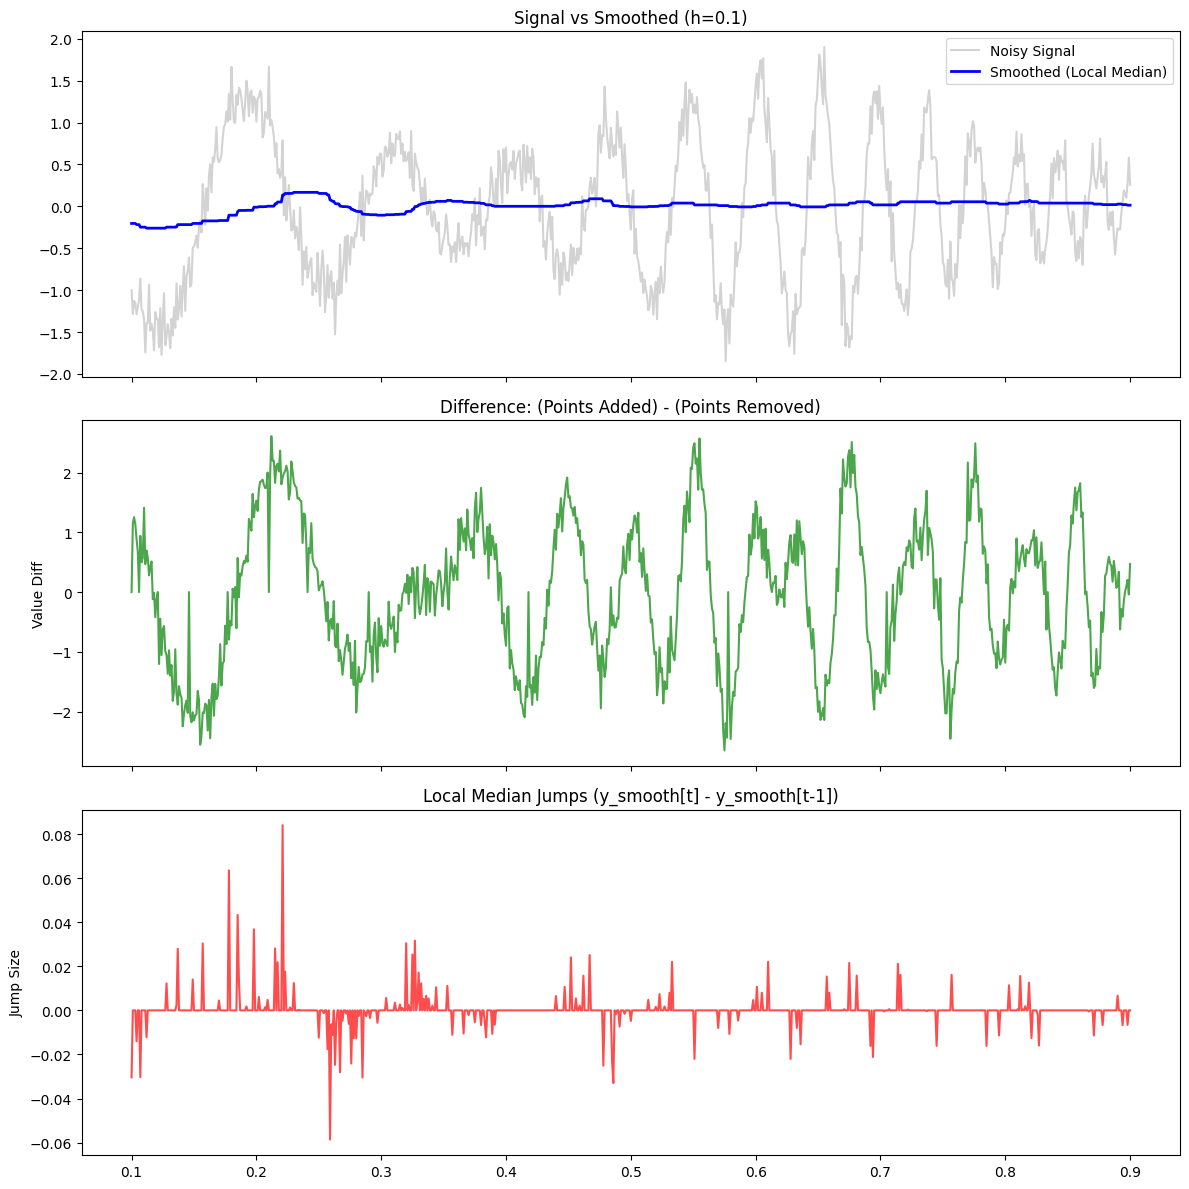

In [75]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# Parameters
n_points = 1000  # Reduced slightly for demo speed
eps = 1e-3
noise_std = 0.2
h_start = 0.1
a = np.sqrt(2)

# Data Generation
x = np.linspace(eps, 1.0, n_points)
y_clean = (1 + 0.5 * np.sin(4 * np.pi * x)) * np.sin(2 * np.pi * (6 * x + 12 * x**3))
np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy = y_clean + noise

# ---------------------------------------------------------
# Analysis Loop (Focusing on the first iteration h_start)
# ---------------------------------------------------------
current_residuals = y_noisy.copy()
h_curr = h_start
n = len(x)
y_smooth = np.zeros(n)

# Lists to store diagnostics
diff_added_removed = np.zeros(n)  # (Mean of Added) - (Mean of Removed)
median_jumps = np.zeros(n)        # y_smooth[i] - y_smooth[i-1]

# To track indices from the previous step
prev_indices = set()

print(f"Processing with h = {h_curr}...")

for i in range(n):
    t = x[i]
    
    # Identify current window indices
    indices_arr = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]
    current_indices = set(indices_arr)
    
    # 1. Calculation: Weighted Median (Your original logic)
    local_res = current_residuals[indices_arr]
    u = (x[indices_arr] - t) / h_curr
    weights = 0.75 * (1 - u**2)
    # weights = weights / (weights.sum())
    
    def loss_function(m):
        return np.sum(np.abs(local_res - m) * weights)
    
    res_opt = minimize_scalar(loss_function)
    if res_opt.success:
        y_smooth[i] = res_opt.x
    else:
        y_smooth[i] = 0 if i==0 else y_smooth[i-1]

    # 2. Analysis: Added vs Removed points
    if i > 0:
        # Find indices that are new (Added) and lost (Removed)
        added_idx = list(current_indices - prev_indices)
        removed_idx = list(prev_indices - current_indices)
        
        val_added = np.mean(current_residuals[added_idx]) if added_idx else 0
        val_removed = np.mean(current_residuals[removed_idx]) if removed_idx else 0
        
        # If we have both added and removed points, record the difference
        # If the window didn't change (rare in continuous x), diff is 0
        if added_idx and removed_idx:
            diff_added_removed[i] = val_added - val_removed
        else:
            diff_added_removed[i] = 0 # Or keep previous
            
        # Calculate Median Jump
        median_jumps[i] = y_smooth[i] - y_smooth[i-1]
    
    prev_indices = current_indices

# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------
# Mask for 0.1 - 0.9 domain to avoid boundary artifacts
mask = (x >= 0.1) & (x <= 0.9)
x_plot = x[mask]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot 1: Original Noisy Signal and Smooth Result
axes[0].plot(x_plot, y_noisy[mask], color='lightgray', label='Noisy Signal')
axes[0].plot(x_plot, y_smooth[mask], color='blue', linewidth=2, label='Smoothed (Local Median)')
axes[0].set_title(f'Signal vs Smoothed (h={h_start})')
axes[0].legend()

# Plot 2: Difference of Added vs Removed Points
# This shows the "shock" to the window from the raw data
axes[1].plot(x_plot, diff_added_removed[mask], color='green', alpha=0.7)
axes[1].set_title('Difference: (Points Added) - (Points Removed)')
axes[1].set_ylabel('Value Diff')

# Plot 3: Median Jumps (Derivative of the smooth signal)
# This shows how the filter actually responded
axes[2].plot(x_plot, median_jumps[mask], color='red', alpha=0.7)
axes[2].set_title('Local Median Jumps (y_smooth[t] - y_smooth[t-1])')
axes[2].set_ylabel('Jump Size')

# Plot 4: Zoomed comparison of Diff vs Jump
# axes[3].plot(x_plot, diff_added_removed[mask], color='green', alpha=0.5, label='In - Out Diff')
# axes[3].plot(x_plot, median_jumps[mask] * 10, color='red', alpha=0.8, label='Median Jump (x10 scaled)') # Scaled for visibility
# axes[3].set_title('Overlay: (In - Out) vs (Median Jump x10)')
# axes[3].legend()

plt.tight_layout()
plt.show()